In [56]:
import pickle

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import uproot_methods
import networkx as nx
import glob
from matplotlib.colors import LogNorm
import pandas
import json
import sklearn
import sklearn.metrics
import bz2
import mpl_toolkits
import mplhep as hep

plt.style.use(hep.style.ROOT)

In [2]:
def midpoints(x):
    return x[:-1] + np.diff(x)/2

def mask_empty(hist):
    h0 = hist[0].astype(np.float64)
    h0[h0<50] = 0
    return (h0, hist[1])

def divide_zero(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    out = np.zeros_like(a)
    np.divide(a, b, where=b>0, out=out)
    return out

In [3]:
!mkdir -p plots

#Raw input data
!wget --no-clobber https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2
    
#predictions file
!wget --no-clobber https://jpata.web.cern.ch/jpata/particleflow/pythia8_ttbar/pred.npz.bz2

#timing file
!wget --no-clobber https://jpata.web.cern.ch/jpata/particleflow/pythia8_ttbar/synthetic_timing.json

--2021-01-20 06:08:21--  https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49728403 (47M) [application/octet-stream]
Saving to: ‘tev14_pythia8_ttbar_0_0.pkl.bz2’

100%[======================================>] 49,728,403  3.12MB/s   in 15s    

2021-01-20 06:08:38 (3.14 MB/s) - ‘tev14_pythia8_ttbar_0_0.pkl.bz2’ saved [49728403/49728403]

File ‘pred.npz.bz2’ already there; not retrieving.

File ‘synthetic_timing.json’ already there; not retrieving.



## Draw a single event

In [4]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "rb"))

In [5]:
#We have a set 100 of events in one file
len(data["ycand"]), len(data["ygen"]), len(data["X"])

(100, 100, 100)

In [6]:
#for each event, we have a number of input elements (X)
# 0-padded arrays of the target particles from generator (ygen) and from the baseline algo (ycand)
data["X"][0].shape, data["ygen"][0].shape, data["ycand"][0].shape, 

((5139, 12), (5139, 7), (5139, 7))

In [7]:
X = data["X"][0]
ycand = data["ycand"][0]
ygen = data["ygen"][0]

In [8]:
#Input element feature vector, defined in ntuplizer.py:make_tower_array,make_track_array:
# tower: (type, Et, eta, sin phi, cos phi, E, Eem, Ehad)
# track: (type, pt, eta, sin phi, cos phi, P, eta_outer, sin phi_outer, cos phi_outer, charge, is_gen_muon, is_gen_electron)
X[0, :]

array([ 2.        ,  0.40810347, -1.26765776, -0.49259257,  0.87026005,
        0.78233682, -2.13861251,  0.99573273, -0.092284  , -1.        ,
        0.        ,  0.        ])

In [9]:
#Get masks for the tracks, ECAL and HCAL elements
msk_trk = X[:, 0] == 2
msk_ecal = (X[:, 0] == 1) & (X[:, 6] > 0)
msk_hcal = (X[:, 0] == 1) & (X[:, 7] > 0)

In [10]:
arr_trk = pandas.DataFrame(X[msk_trk], columns=["id", "pt", "eta", "sphi", "cphi", "p", "eta_outer", "sphi_outer", "cphi_outer", "charge", "is_gen_muon", "is_gen_ele"])
arr_ecal = pandas.DataFrame(X[msk_ecal][:, :6], columns=["id", "et", "eta", "sphi", "cphi", "e"])
arr_hcal = pandas.DataFrame(X[msk_hcal][:, :6], columns=["id", "et", "eta", "sphi", "cphi", "e"])

arr_gen = pandas.DataFrame(ygen[ygen[:, 0]!=0], columns=["id", "charge", "pt", "eta", "sphi", "cphi", "energy"])

In [74]:
#compute track x,y on the inner and outer surfaces
points_a = arr_trk["eta"].values, np.arctan2(arr_trk["sphi"], arr_trk["cphi"]).values
points_b = arr_trk["eta_outer"].values, np.arctan2(arr_trk["sphi_outer"], arr_trk["cphi_outer"]).values

r1 = 0.5
r2 = 1.0
r3 = 1.2
r4 = 1.4
r5 = 1.6

points = []
for i in range(len(arr_trk)):
    point = []
    point.append((0,0,0))
    point.append((points_a[0][i], r1*np.sin(points_a[1][i]), r1*np.cos(points_a[1][i])))
    point.append((points_b[0][i], r2*np.sin(points_b[1][i]), r2*np.cos(points_b[1][i])))
    points.append(point)
    
points_etaphi = []
for i in range(len(arr_trk)):
    point = []
    point.append((points_a[0][i], points_a[1][i]))
    point.append((points_b[0][i], points_b[1][i]))
    points_etaphi.append(point)
    
    
points_xyz = []
for i in range(len(arr_trk)):
    point = []
    point.append((0,0,0))
    point.append((r1*np.sinh(points_a[0][i]), r1*np.sin(points_a[1][i]), r1*np.cos(points_a[1][i])))
    point.append((r2*np.sinh(points_b[0][i]), r2*np.sin(points_b[1][i]), r2*np.cos(points_b[1][i])))
    points.append(point)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


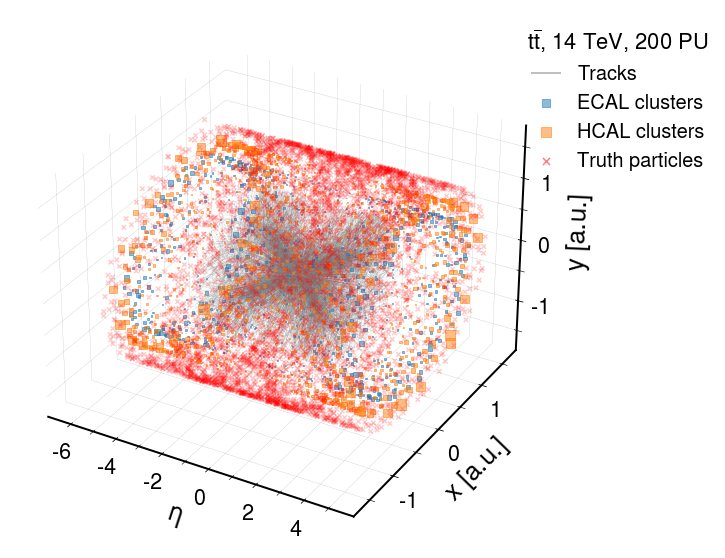

In [67]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111, projection='3d')

lc = mpl_toolkits.mplot3d.art3d.Line3DCollection(points, linewidths=0.2, color="gray", alpha=0.5)
ax.add_collection(lc)
# just for better legend
lc2 = mpl_toolkits.mplot3d.art3d.Line3DCollection([], linewidths=2, color="gray", alpha=0.5, label="Tracks")
ax.add_collection(lc2)

ax.scatter(arr_ecal["eta"], r3*arr_ecal["sphi"], r3*arr_ecal["cphi"], s=0.1*arr_ecal["e"], color=u'#1f77b4', marker="s", alpha=0.5)
ax.scatter(arr_hcal["eta"], r4*arr_hcal["sphi"], r4*arr_hcal["cphi"], s=0.1*arr_hcal["e"], color=u'#ff7f0e', marker="s", alpha=0.5)
ax.scatter(arr_gen["eta"], r5*arr_gen["sphi"], r5*arr_gen["cphi"], alpha=0.2, marker="x", color="red")
# just for better legend
ax.scatter([],[], [], alpha=0.5, marker="s", s = 50, color=u'#1f77b4', label="ECAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="s", s = 100, color=u'#ff7f0e', label="HCAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="x", s = 50, color="red", label="Truth particles")


ax.set_zlabel(r"$y$ [a.u.]",labelpad=15)
ax.set_ylabel(r"$x$ [a.u.]",labelpad=15)
ax.set_xlabel(r"$\eta$",labelpad=15)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.zaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.zaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.yaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.zaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

legend = plt.legend(title =r"$t\overline{t}$, 14 TeV, 200 PU",frameon=False, bbox_to_anchor=(0.92, 1.0), loc='upper left',fontsize=20)
plt.setp(legend.get_title(),fontsize=22)
#plt.title("Simulated event with PU200")
plt.savefig("plots/event.pdf", bbox_inches="tight")
plt.savefig("plots/event.png", bbox_inches="tight", dpi=200)
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


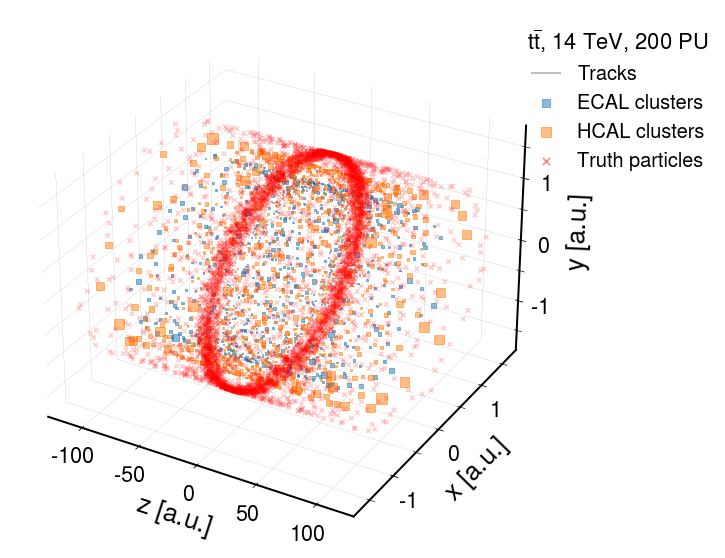

In [91]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111, projection='3d')

lc = mpl_toolkits.mplot3d.art3d.Line3DCollection(points_xyz, linewidths=0.2, color="gray", alpha=0.5)
ax.add_collection(lc)
# just for better legend
lc2 = mpl_toolkits.mplot3d.art3d.Line3DCollection([], linewidths=2, color="gray", alpha=0.5, label="Tracks")
ax.add_collection(lc2)

ax.scatter(r3*np.sinh(arr_ecal["eta"]), r3*arr_ecal["sphi"], r3*arr_ecal["cphi"], s=0.1*arr_ecal["e"], color=u'#1f77b4', marker="s", alpha=0.5)
ax.scatter(r4*np.sinh(arr_hcal["eta"]), r4*arr_hcal["sphi"], r4*arr_hcal["cphi"], s=0.1*arr_hcal["e"], color=u'#ff7f0e', marker="s", alpha=0.5)
ax.scatter(r5*np.sinh(arr_gen["eta"]), r5*arr_gen["sphi"], r5*arr_gen["cphi"], alpha=0.2, marker="x", color="red")
# just for better legend
ax.scatter([],[], [], alpha=0.5, marker="s", s = 50, color=u'#1f77b4', label="ECAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="s", s = 100, color=u'#ff7f0e', label="HCAL clusters")
ax.scatter([],[], [], alpha=0.5, marker="x", s = 50, color="red", label="Truth particles")


ax.set_zlabel(r"$y$ [a.u.]",labelpad=15)
ax.set_ylabel(r"$x$ [a.u.]",labelpad=15)
ax.set_xlabel(r"$z$ [a.u.]",labelpad=15)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.zaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.zaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.yaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})
ax.zaxis._axinfo["grid"].update({"linewidth":0.2, "color" : "gray", "which":"major", "linestyle":"--","alpha":0.1})

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


ax.set_xlim(-125, 125)


legend = plt.legend(title =r"$t\overline{t}$, 14 TeV, 200 PU",frameon=False, bbox_to_anchor=(0.92, 1.0), loc='upper left',fontsize=20)
plt.setp(legend.get_title(),fontsize=22)
#plt.title("Simulated event with PU200")
plt.savefig("plots/event_xyz.pdf", bbox_inches="tight")
plt.savefig("plots/event_xyz.png", bbox_inches="tight", dpi=200)
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


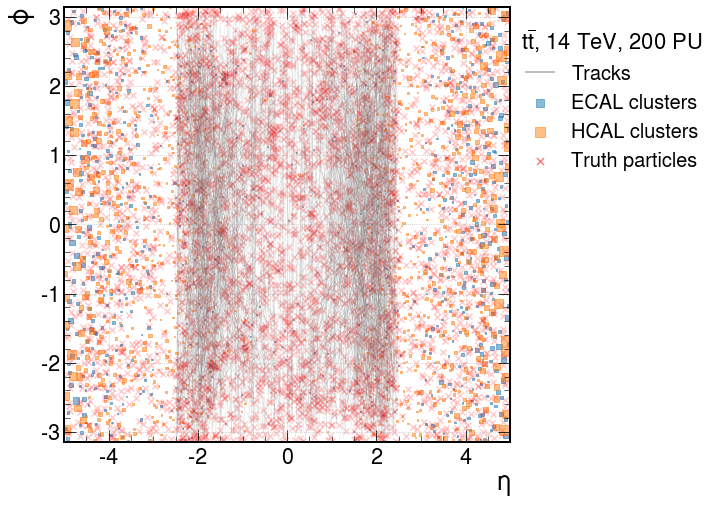

In [73]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
from matplotlib.collections import LineCollection
lc = LineCollection(points_etaphi, linewidths=0.2, color="gray", alpha=0.5)
ax.add_collection(lc)
# just for better legend
lc2 = LineCollection([], linewidths=2, color="gray", alpha=0.5, label="Tracks")
ax.add_collection(lc2)

ax.scatter(arr_ecal["eta"], np.arctan2(arr_ecal["sphi"],arr_ecal["cphi"]), s=0.1*arr_ecal["e"], color=u'#1f77b4', marker="s", alpha=0.5)
ax.scatter(arr_hcal["eta"], np.arctan2(arr_hcal["sphi"],arr_hcal["cphi"]), s=0.1*arr_hcal["e"], color=u'#ff7f0e', marker="s", alpha=0.5)
ax.scatter(arr_gen["eta"], np.arctan2(arr_gen["sphi"],arr_gen["cphi"]), alpha=0.2, marker="x", color="red")
# just for better legend
ax.scatter([],[], alpha=0.5, marker="s", s = 50, color=u'#1f77b4', label="ECAL clusters")
ax.scatter([],[], alpha=0.5, marker="s", s = 100, color=u'#ff7f0e', label="HCAL clusters")
ax.scatter([],[], alpha=0.5, marker="x", s = 50, color="red", label="Truth particles")


ax.set_ylabel(r"$\phi$")
ax.set_xlabel(r"$\eta$")
ax.set_ylim(-np.pi, np.pi)
ax.set_xlim(-5, 5)

ax.grid(True)

legend = plt.legend(title =r"$t\overline{t}$, 14 TeV, 200 PU",frameon=False, bbox_to_anchor=(0.98, 1.0), loc='upper left',fontsize=20)
plt.setp(legend.get_title(),fontsize=22)
#plt.title("Simulated event with PU200")
plt.savefig("plots/event_etaphi.pdf", bbox_inches="tight")
plt.savefig("plots/event_etaphi.png", bbox_inches="tight", dpi=200)
plt.show()

# Analysis of predictions

Once the training is done, we can generate the pred.npz file using the following:
```bash
singularity exec --nv ~/HEP-KBFI/singularity/base.simg python3 ../mlpf/tensorflow/delphes_model.py --action validate --weights weights.300-*.hdf5
```

In [ ]:
#Load the predictions file from the model (this can take a while, as the file is compressed and pretty large)
fi = np.load(bz2.BZ2File("pred.npz.bz2", "rb"))

#if you run `bzip -d pred.npz.bz2` locally, you can use this:
# fi = np.load(open("pred.npz", "rb"))
ygen = fi["ygen"]
ycand = fi["ycand"]
ypred = fi["ypred"]
X = fi["X"]

In [ ]:
#Flatten the events
ygen = ygen.reshape((ygen.shape[0]*ygen.shape[1], ygen.shape[2]))
ycand = ycand.reshape((ycand.shape[0]*ycand.shape[1], ycand.shape[2]))
ypred = ypred.reshape((ypred.shape[0]*ypred.shape[1], ypred.shape[2]))
X = X.reshape((X.shape[0]*X.shape[1], X.shape[2]))

In [ ]:
print(ygen.shape)
print(ycand.shape)
print(ypred.shape)

In [ ]:
b = np.linspace(0, 100, 41)

msk_pid1 = (ygen[:, 0]==1)
msk_pid2 = (ygen[:, 0]==2)
msk_pid3 = (ygen[:, 0]==3)
msk_pid4 = (ygen[:, 0]==4)
msk_pid5 = (ygen[:, 0]==5)

h1 = np.histogram(ygen[msk_pid1, 2], bins=b)
h2 = np.histogram(ygen[msk_pid2, 2], bins=b)
h3 = np.histogram(ygen[msk_pid3, 2], bins=b)
h4 = np.histogram(ygen[msk_pid4, 2], bins=b)
h5 = np.histogram(ygen[msk_pid5, 2], bins=b)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax1, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])

ax1.legend(loc="best", frameon=False)
ax1.set_yscale("log")
ax1.set_ylim(1e1, 1e9)
ax1.set_xlabel(r"Truth particle $p_\mathrm{T}$ [GeV]")
ax1.set_ylabel("Truth particles")

b = np.linspace(-8, 8, 41)
h1 = np.histogram(ygen[msk_pid1, 3], bins=b)
h2 = np.histogram(ygen[msk_pid2, 3], bins=b)
h3 = np.histogram(ygen[msk_pid3, 3], bins=b)
h4 = np.histogram(ygen[msk_pid4, 3], bins=b)
h5 = np.histogram(ygen[msk_pid5, 3], bins=b)
xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax2, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])
ax2.legend(loc="best", frameon=False)
ax2.set_yscale("log")
ax2.set_ylim(1e1, 1e10)
ax2.set_xlabel("Truth particle $\eta$")
ax2.set_ylabel("Truth particles")
plt.savefig("plots/gen_pt_eta.pdf", bbox_inches="tight")

In [ ]:
ranges = {
    "pt": np.linspace(0, 10, 61),
    "eta": np.linspace(-5, 5, 61),
    "sphi": np.linspace(-1, 1, 61),
    "cphi": np.linspace(-1, 1, 61),
    "energy": np.linspace(0, 100, 61)
}

pid_names = {
    1: "Charged hadrons",
    2: "Neutral hadrons",
    3: "Photons",
    4: "Electrons",
    5: "Muons",
}
var_names = {
    "pt": r"$p_\mathrm{T}$ [GeV]",
    "eta": r"$\eta$",
    "sphi": r"$\mathrm{sin} \phi$",
    "cphi": r"$\mathrm{cos} \phi$",
    "energy": r"$E$ [GeV]"
}

var_names_nounit = {
    "pt": r"$p_\mathrm{T}$",
    "eta": r"$\eta$",
    "sphi": r"$\mathrm{sin} \phi$",
    "cphi": r"$\mathrm{cos} \phi$",
    "energy": r"$E$"
}

var_names_bare = {
    "pt": "p_\mathrm{T}",
    "eta": "\eta",
    "energy": "E",
}


var_indices = {
    "pt": 2,
    "eta": 3,
    "sphi": 4,
    "cphi": 5,
    "energy": 6
}

### Number of particles

In [ ]:
def plot_num_particles_pid(pid, ax=None):
    if not ax:
        plt.figure(figsize=(4,4))
        ax = plt.axes()
        
    x1 = np.sum(fi["ygen"][:, :, 0]==pid, axis=1)
    x2 = np.sum(fi["ypred"][:, :, 0]==pid, axis=1)
    x3 = np.sum(fi["ycand"][:, :, 0]==pid, axis=1)

    v0 = np.min([np.min(x1), np.min(x2), np.min(x3)])
    v1 = np.max([np.max(x1), np.max(x2), np.max(x3)])

    #draw only a random sample of the events to avoid overcrowding
    inds = np.random.permutation(len(x1))[:1000]
    
    ax.scatter(
        x1[inds],
        x3[inds],
        marker="o",
        label="Rule-based PF (r={:.4f})".format(np.corrcoef(x1, x3)[0,1]),
        alpha=0.5
    )

    ax.scatter(
        x1[inds],
        x2[inds],
        marker="^",
        label="MLPF (r={:.4f})".format(np.corrcoef(x1, x2)[0,1]),
        alpha=0.5
    )
    leg = ax.legend(loc="best", frameon=False, title=pid_names[pid])
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax.plot([v0, v1], [v0, v1], color="black", ls="--")
    #ax.set_title(pid_names[pid])
    ax.set_xlabel("Truth particles / event")
    ax.set_ylabel("Reconstructed particles / event")
    #plt.title("Particle multiplicity, {}".format(pid_names[pid]))
    #plt.savefig("plots/num_particles_pid{}.pdf".format(pid), bbox_inches="tight")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))
plot_num_particles_pid(1, ax1)
plot_num_particles_pid(2, ax2)
plt.tight_layout()
plt.savefig("plots/num_particles.pdf")
plt.savefig("plots/num_particles.png", dpi=200)

In [ ]:
# for pid in [1,2,3,4,5]:
#     for var in ["pt", "eta", "sphi", "cphi", "energy"]:
#         rng = ranges[var]

#         msk = (ygen[:, 0]==pid) & (ypred[:, 0]==pid) & (ycand[:, 0]==pid)

#         plt.figure(figsize=(6,5))
#         plt.title(pid_names[pid])
#         plt.hist2d(
#             ygen[msk, var_indices[var]],
#             ypred[msk, var_indices[var]],
#             bins=(rng, rng),
#             cmap="Blues",
#             norm=matplotlib.colors.LogNorm()
#         )
#         plt.colorbar()
#         plt.xlabel("Gen {}".format(var_names[var]))
#         plt.ylabel("MLPF {}".format(var_names[var]))
#         plt.savefig("plots/corr_mlpf_pid{}_{}.pdf".format(pid, var), bbox_inches="tight")

#         plt.figure(figsize=(6,5))
#         plt.title(pid_names[pid])
#         plt.hist2d(
#             ygen[msk, var_indices[var]],
#             ycand[msk, var_indices[var]],
#             bins=(rng, rng),
#             cmap="Blues",
#             norm=matplotlib.colors.LogNorm()
#         );
#         plt.xlabel("Gen {}".format(var_names[var]))
#         plt.ylabel("DelphesPF {}".format(var_names[var]))
#         plt.colorbar()
#         plt.savefig("plots/corr_delphespf_pid{}_{}.pdf".format(pid, var), bbox_inches="tight")

## Fake rate plots

In [ ]:
def draw_efficiency_fakerate(pid, var, bins, both=True):
    var_idx = var_indices[var]

    msk_gen = ygen[:, 0]==pid
    msk_pred = ypred[:, 0]==pid
    msk_cand = ycand[:, 0]==pid

    hist_gen = np.histogram(ygen[msk_gen, var_idx], bins=bins);
    hist_cand = np.histogram(ygen[msk_gen & msk_cand, var_idx], bins=bins);
    hist_pred = np.histogram(ygen[msk_gen & msk_pred, var_idx], bins=bins);
    
    hist_gen = mask_empty(hist_gen)
    hist_cand = mask_empty(hist_cand)
    hist_pred = mask_empty(hist_pred)

    #efficiency plot
    if both:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 1*8))

    #ax1.set_title("reco efficiency for {}".format(pid_names[pid]))
    ax1.errorbar(
        midpoints(hist_gen[1]),
        divide_zero(hist_cand[0], hist_gen[0]),
        divide_zero(np.sqrt(hist_gen[0]), hist_gen[0]) * divide_zero(hist_cand[0], hist_gen[0]),
        lw=0, label="Rule-based PF", elinewidth=2, marker=".",markersize=10)
    ax1.errorbar(
        midpoints(hist_gen[1]),
        divide_zero(hist_pred[0], hist_gen[0]),
        divide_zero(np.sqrt(hist_gen[0]), hist_gen[0]) * divide_zero(hist_pred[0], hist_gen[0]),
        lw=0, label="MLPF", elinewidth=2, marker=".",markersize=10)
    ax1.legend(frameon=False, loc=0, title=pid_names[pid])
    ax1.set_ylim(0,1.2)
    ax1.set_xlabel(var_names[var])
    ax1.set_ylabel("Efficiency")

    hist_cand2 = np.histogram(ygen[msk_cand & (ygen[:, 0]!=0), var_idx], bins=bins);
    hist_pred2 = np.histogram(ygen[msk_pred & (ygen[:, 0]!=0), var_idx], bins=bins);
    hist_cand_gen2 = np.histogram(ygen[msk_cand & ~msk_gen & (ygen[:, 0]!=0), var_idx], bins=bins);
    hist_pred_gen2 = np.histogram(ygen[msk_pred & ~msk_gen & (ygen[:, 0]!=0), var_idx], bins=bins);

    hist_cand2 = mask_empty(hist_cand2)
    hist_cand_gen2 = mask_empty(hist_cand_gen2)
    hist_pred2 = mask_empty(hist_pred2)
    hist_pred_gen2 = mask_empty(hist_pred_gen2)
    
    if both:
        #fake rate plot
        #ax2.set_title("reco fake rate for {}".format(pid_names[pid]))
        ax2.errorbar(
            midpoints(hist_cand2[1]),
            divide_zero(hist_cand_gen2[0], hist_cand2[0]),
            divide_zero(np.sqrt(hist_cand_gen2[0]), hist_cand2[0]),
            lw=0, label="Rule-based PF", elinewidth=2, marker=".",markersize=10)
        ax2.errorbar(
            midpoints(hist_pred2[1]),
            divide_zero(hist_pred_gen2[0], hist_pred2[0]),
            divide_zero(np.sqrt(hist_pred_gen2[0]), hist_pred2[0]),
            lw=0, label="MLPF", elinewidth=2, marker=".",markersize=10)
        ax2.legend(frameon=False, loc=0, title=pid_names[pid])
        ax2.set_ylim(0, 1.0)
        #plt.yscale("log")
        ax2.set_xlabel(var_names[var])
        ax2.set_ylabel("Fake rate")
    
    plt.savefig("plots/eff_fake_pid{}_{}.pdf".format(pid, var))


In [ ]:
draw_efficiency_fakerate(1, "pt", np.linspace(0, 3, 61), both=False)

In [ ]:
draw_efficiency_fakerate(1, "eta", np.linspace(-3, 3, 61), both=False)

In [ ]:
draw_efficiency_fakerate(
    2, "energy", np.linspace(5, 55, 61))

In [ ]:
draw_efficiency_fakerate(
    2, "eta", np.linspace(-6, 6, 61)
)

## Resolution plots

In [ ]:
def plot_reso(pid, var, rng, ax=None):
    var_idx = var_indices[var]
    msk = (ygen[:, 0]==pid) & (ypred[:, 0]==pid) & (ycand[:, 0]==pid)
    bins = np.linspace(-rng, rng, 100)
    yg = ygen[msk, var_idx]
    yp = ypred[msk, var_idx]
    yc = ycand[msk, var_idx]
    ratio_mlpf = (yp - yg) / yg
    ratio_dpf = (yc - yg) / yg
    
    #remove outliers for std value computation
    outlier = 10
    ratio_mlpf[ratio_mlpf<-outlier] = -outlier
    ratio_mlpf[ratio_mlpf>outlier] = outlier
    ratio_dpf[ratio_dpf<-outlier] = -outlier
    ratio_dpf[ratio_dpf>outlier] = outlier
    
    res_dpf = np.mean(ratio_dpf), np.std(ratio_dpf)
    res_mlpf = np.mean(ratio_mlpf), np.std(ratio_mlpf)
    
    if ax is None:
        plt.figure(figsize=(4, 4))
        ax = plt.axes()
        
    #plt.title("{} resolution for {}".format(var_names_nounit[var], pid_names[pid]))
    ax.hist(ratio_dpf, bins=bins, histtype="step", lw=2, label="Rule-based PF\n$\mu={:.2f},\\ \sigma={:.2f}$".format(*res_dpf));
    ax.hist(ratio_mlpf, bins=bins, histtype="step", lw=2, label="MLPF\n$\mu={:.2f},\\ \sigma={:.2f}$".format(*res_mlpf));
    ax.legend(frameon=False, title=pid_names[pid])
    ax.set_xlabel("{nounit} resolution, $({bare}^\prime - {bare})/{bare}$".format(nounit=var_names_nounit[var],bare=var_names_bare[var]))
    ax.set_ylabel("Particles")
    #plt.ylim(0, ax.get_ylim()[1]*2)
    ax.set_ylim(1, 1e10)
    ax.set_yscale("log")

    return {"dpf": res_dpf, "mlpf": res_mlpf}

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

res_ch_had_pt = plot_reso(1, "pt", 2, ax=ax1)
res_ch_had_eta = plot_reso(1, "eta", 0.2, ax=ax2)

ax2.set_ylim(100, 10**10)
#ax1.set_title("Charged hadrons")
plt.tight_layout()
plt.savefig("plots/res_pid1.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

res_n_had_e = plot_reso(2, "energy", 5, ax=ax1)
res_n_had_eta = plot_reso(2, "eta", 0.5, ax=ax2)

#ax1.set_title("Neutral hadrons")
plt.tight_layout()
plt.savefig("plots/res_pid2.pdf")
plt.savefig("plots/res_pid2.png", dpi=200)

## Confusion matrices

In [ ]:
confusion = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ycand[:, 0], normalize="true"
)

confusion2 = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ypred[:, 0], normalize="true"
)


confusion_unnorm = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ycand[:, 0],
)

confusion2_unnorm = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ypred[:, 0],
)

In [ ]:
np.round(confusion, 2)

In [ ]:
np.round(confusion2, 2)

In [ ]:
sklearn.metrics.accuracy_score(ygen[:, 0], ycand[:, 0])

In [ ]:
sklearn.metrics.accuracy_score(ygen[:, 0], ypred[:, 0])

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          ax=None):
    """

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    if not ax:
        fig = plt.figure(figsize=(5, 4))
        ax = plt.axes()
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(target_names, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(target_names, rotation=45)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    ax.set_ylabel('True PID')
    ax.set_xlabel('Reconstructed PID')
    ax.set_xlim(-1, len(target_names))
    ax.set_ylim(-1, len(target_names))
    #ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

plot_confusion_matrix(confusion, ["None", "Ch. had", "N. had", "$\gamma$", r"$e^\pm$", r"$\mu^\pm$"], ax=ax1)
plot_confusion_matrix(confusion2, ["None", "Ch. had", "N. had", "$\gamma$", r"$e^\pm$", r"$\mu^\pm$"], ax=ax2)

ax1.set_xlabel("")
ax1.set_title("Rule-based PF")
ax2.set_title("MLPF")
plt.tight_layout()
plt.savefig("plots/confusion_normed.pdf")

### Results table

In [ ]:
metrics_delphes = {
    "ch_had_eff": confusion_unnorm[1, 1] / np.sum(confusion_unnorm[1, :]),
    "n_had_eff": confusion_unnorm[2, 2] / np.sum(confusion_unnorm[2, :]),

    "ch_had_fake": 1.0 - confusion_unnorm[1, 1] / np.sum(confusion_unnorm[:, 1]),
    "n_had_fake": 1.0 - confusion_unnorm[2, 2] / np.sum(confusion_unnorm[:, 2]),
    
    "res_ch_had_eta_s": res_ch_had_eta["dpf"][1],
    "res_ch_had_pt_s": res_ch_had_pt["dpf"][1],
    
    "res_n_had_eta_s": res_n_had_eta["dpf"][1],
    "res_n_had_e_s": res_n_had_e["dpf"][1],
}

metrics_mlpf = {
    "ch_had_eff": confusion2_unnorm[1, 1] / np.sum(confusion2_unnorm[1, :]),
    "n_had_eff": confusion2_unnorm[2, 2] / np.sum(confusion2_unnorm[2, :]),

    "ch_had_fake": 1.0 - confusion2_unnorm[1, 1] / np.sum(confusion2_unnorm[:, 1]),
    "n_had_fake": 1.0 - confusion2_unnorm[2, 2] / np.sum(confusion2_unnorm[:, 2]),
    
    
    "res_ch_had_eta_s": res_ch_had_eta["mlpf"][1],
    "res_ch_had_pt_s": res_ch_had_pt["mlpf"][1],

    "res_n_had_eta_s": res_n_had_eta["mlpf"][1],
    "res_n_had_e_s": res_n_had_e["mlpf"][1],
}

In [ ]:
metrics_delphes

In [ ]:
metrics_mlpf

In [ ]:
names = [
    "Efficiency",
    "Fake rate",
    r"$p_\mathrm{T}$ ($E$) resolution",
    r"$\eta$ resolution"
]

for n, ks in zip(names, [
    ("ch_had_eff", "n_had_eff"),
    ("ch_had_fake", "n_had_fake"),
    ("res_ch_had_pt_s", "res_n_had_e_s"),
    ("res_ch_had_eta_s", "res_n_had_eta_s")
    ]):
    
    k0 = ks[0]
    k1 = ks[1]
    print("{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
        n, metrics_delphes[k0], metrics_mlpf[k0], metrics_delphes[k1], metrics_mlpf[k1]))

## Scaling of the model inference time with synthetic data

The scaling of the model timing is done using synthetic data with the following command:
```bash
singularity exec --nv ~/HEP-KBFI/singularity/base.simg python3 ../mlpf/tensorflow/delphes_model.py --action timing --weights weights.300-*.hdf5
```

In [ ]:
timing_data_d = json.load(open("synthetic_timing.json", "r"))
timing_data_d = sum(timing_data_d, [])

In [ ]:
timing_data = pandas.DataFrame.from_records(timing_data_d)

In [ ]:
lines = timing_data[timing_data["batch_size"] == 1]
times_b1 = lines.groupby("event_size").apply(lambda x: np.mean(x["time_per_event"]))


lines = timing_data[timing_data["event_size"] == 128*50]
times_ev1 = lines.groupby("batch_size").apply(lambda x: np.mean(x["time_per_event"]))

lines = timing_data[timing_data["event_size"] == 128*20]
times_ev2 = lines.groupby("batch_size").apply(lambda x: np.mean(x["time_per_event"]))

lines = timing_data[timing_data["event_size"] == 128*10]
times_ev3 = lines.groupby("batch_size").apply(lambda x: np.mean(x["time_per_event"]))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

bins = [128*10, 128*20, 128*30, 128*40, 128*50, 128*60, 128*70, 128*80, 128*90, 128*100]
ax1.plot(times_b1.keys(), times_b1.values, marker="o", label="MLPF",lw=2,markersize=10)
ax1.axvline(128*50, color="black", ymin=0, ymax=0.39, lw=2,ls='--')
#ax1.set_xticks(bins)

#ax1.set_xticklabels([128*10, 128*20, 128*40, 128*80, 128*160])
ax1.text(128*50*1.02, 10, r"$t\overline{t}$, 14 TeV, 200 PU")
ax1.set_ylim(0,120)
#plt.xlim(0,25000)
ax1.set_xlabel("Average event size [elements]")
ax1.set_ylabel("Average runtime / event [ms]")
ax1.legend(loc="best", frameon=False)

ax2.plot(times_ev3.keys(), times_ev3.values / times_ev3.values[0], marker="o", label="40 PU",lw=2,markersize=10)
ax2.plot(times_ev2.keys(), times_ev2.values / times_ev2.values[0], marker="^", label="80 PU",lw=2,markersize=10)
ax2.plot(times_ev1.keys(), times_ev1.values / times_ev1.values[0], marker="v", label="200 PU",lw=2,markersize=10)
ax2.set_xticks([1, 2, 3, 4])
ax2.set_xlabel("Batch size [events]")
ax2.set_ylabel("Relative inference time [a.u.]")
ax2.legend(loc="best", frameon=False)

plt.savefig("plots/inference_time.pdf", bbox_inches="tight")

## TPR/FPR plots

In [ ]:
import scipy

ygen2 = fi["ygen"]
ycand2 = fi["ycand"]
ypred2 = fi["ypred"]
ypred_raw2 = fi["ypred_raw"]
ypred_sm2 = scipy.special.softmax(ypred_raw2, axis=-1)

X2 = fi["X"]

In [ ]:
pid = 2
preds = ypred_sm2[:, :, pid].flatten()
msk_true = (ygen2[:, :, 0] == pid).flatten()
msk_cand = (ycand2[:, :, 0] == pid).flatten()

tpr_delphes = np.sum((msk_cand==True) & (msk_true==True)) /  np.sum(msk_true==True)
fpr_delphes = np.sum((msk_cand==True) & (msk_true==False)) /  np.sum(msk_cand==True)

In [ ]:
plt.figure(figsize=(8,8))
fpr, tpr, thresh = sklearn.metrics.roc_curve(msk_true, preds)
plt.plot(fpr_delphes, tpr_delphes, marker="^", label="Rule-based PF", lw=0)
plt.plot(fpr, tpr, label="MLPF")
plt.xlim(0.0, 0.25)
plt.ylim(0.8,1.0)
plt.xlabel("Fake rate")
plt.ylabel("Efficiency")
plt.title("MLPF classifier output for {}".format(pid_names[pid]))
plt.legend(loc="best")